In [3]:
import torch
import torch.nn as nn

def img_size(in_size, kernel_size, padding, stride):
    return (in_size - kernel_size + 2 * padding) // stride + 1

class ConvNet(nn.Module):
    def __init__(self, 
                 in_channels=3, 
                 num_filters=[32, 64, 128, 256, 512], 
                 filter_size=[3, 3, 5, 5, 7],
                 activation=nn.ReLU(), 
                 stride=1, 
                 padding=1, 
                 pool_size=(2, 2), 
                 fc_dims=[512], 
                 num_classes=10,
                 dropout=0.5, 
                 batch_norm='Yes'):
        super(ConvNet, self).__init__()

        self.activation = activation
        self.batch_norm = batch_norm
        self.pool = nn.MaxPool2d(pool_size, stride=2)

        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        self.drop_layers = nn.ModuleList()

        in_ch = in_channels
        current_size = 224  # assuming input image size is 224x224

        # Convolution layers....................................
        for i in range(len(num_filters)):
            out_ch = num_filters[i]
            k = filter_size[i]

            self.conv_layers.append(
                nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=stride, padding=padding)
            )
            self.drop_layers.append(nn.Dropout2d(dropout))

            if batch_norm == 'Yes':
                self.bn_layers.append(nn.BatchNorm2d(out_ch))
            else:
                self.bn_layers.append(nn.Identity())

            # update spatial size.....................................
            current_size = img_size(current_size, k, padding, stride) 
            current_size = img_size(current_size, pool_size[0], 0, 2)  
            in_ch = out_ch

        flat_size = num_filters[-1] * current_size * current_size

        # Fully connected layers............................
        self.fc_layers = nn.ModuleList()
        self.fc_bn_layers = nn.ModuleList()

        prev_dim = flat_size
        for dim in fc_dims:
            self.fc_layers.append(nn.Linear(prev_dim, dim))
            if batch_norm == 'Yes':
                self.fc_bn_layers.append(nn.BatchNorm1d(dim))
            else:
                self.fc_bn_layers.append(nn.Identity())
            prev_dim = dim

        self.fc_drop = nn.Dropout1d(dropout)
        self.out = nn.Linear(prev_dim, num_classes)

    def forward(self, x):
        # Convolutional layers.............................
        for conv, bn, drop in zip(self.conv_layers, self.bn_layers, self.drop_layers):
            x = conv(x)
            x = bn(x)
            x = self.activation(x)
            x = self.pool(x)
            x = drop(x)

        # Flattening for dense layers.........................
        x = x.view(x.size(0), -1)

        # Fully connected ...................................
        for fc, bn in zip(self.fc_layers, self.fc_bn_layers):
            x = fc(x)
            x = bn(x)
            x = self.activation(x)
            x = self.fc_drop(x)

        # Output layer..........................
        x = self.out(x)
        return x


In [2]:
import torch
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, random_split
import numpy as np

def load_dataloaders(train_data_dir, data_aug='Yes', batch_size=64, val_split=0.2):
    # Define image transformations
    basic_resize = transforms.Resize((224, 224))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    crop_resize = transforms.RandomResizedCrop(224)
    flip = transforms.RandomHorizontalFlip()
    color_shift = transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)
    rotate = transforms.RandomRotation(20)

    # Apply augmentation or not
    if data_aug == 'Yes':
        transform_pipeline = transforms.Compose([
            crop_resize,
            color_shift,
            flip,
            rotate,
            to_tensor,
            normalize
        ])
    else:
        transform_pipeline = transforms.Compose([
            basic_resize,
            to_tensor,
            normalize
        ])

    # Loading dataset.................................................
    full_dataset = ImageFolder(root=train_data_dir, transform=transform_pipeline)
    total_len = len(full_dataset)
    val_len = int(val_split * total_len)
    train_len = total_len - val_len

    # Splitting the dataset using torch's random_split..........................
    train_set, val_set = random_split(full_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))

    # Creating dataloaders...............................
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return {
        'train': train_loader,
        'val': val_loader,
        'classes': full_dataset.classes
    }


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, train_loader, val_loader, num_epochs, device, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_loss = running_loss / total

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_preds = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += (val_preds == val_labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_loss_avg = val_loss / val_total

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% || "
              f"Val Loss: {val_loss_avg:.4f} | Val Acc: {val_accuracy:.2f}%")


In [5]:
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_with_wandb():
    wandb.init(project="MA23M021_A2_Part-A", name="run-" + wandb.util.generate_id())
    config = wandb.config

    # Explicitly log hyperparameters to enable sweep visualizations
    wandb.config.update({
    "kernel_size": config.kernel_size,
    "dropout": config.dropout,
    "activation": config.activation,
    "fc_dims": config.fc_dims,
    "batch_norm": config.batch_norm,
    "filter_org": config.filter_org,
    "data_aug": config.data_aug,
    "lr": config.lr,
    "epochs": config.epochs,
    "batch_size": config.batch_size
}, allow_val_change=True)


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Activation function mapping
    activation_map = {
        'relu': nn.ReLU(),
        'mish': nn.Mish(),
        'silu': nn.SiLU(),
        'gelu': nn.GELU()
    }

    # Create the model using config values
    model = ConvNet(
        in_channels=3,
        num_filters=config.filter_org,
        filter_size=config.kernel_size,
        activation=activation_map[config.activation],
        dropout=config.dropout,
        batch_norm=config.batch_norm,
        fc_dims=config.fc_dims,
        num_classes=10
    ).to(device)

    # Load data with augmentation and validation split
    dataloaders = load_dataloaders(
        train_data_dir='/kaggle/input/natrue-12k/inaturalist_12K/train',
        data_aug=config.data_aug,
        batch_size=config.batch_size,
        val_split=0.2
    )

    train_loader = dataloaders['train']
    val_loader = dataloaders['val']

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.lr)

    for epoch in range(config.epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            total += labels.size(0)
            train_correct += (preds == labels).sum().item()

        train_acc = 100 * train_correct / total
        train_loss /= total

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item() * val_images.size(0)
                _, val_preds = val_outputs.max(1)
                val_total += val_labels.size(0)
                val_correct += (val_preds == val_labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_loss /= val_total

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })

        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")



In [6]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'kernel_size': {
            'values': [
                [3, 3, 3, 3, 3],
                [3, 5, 5, 7, 7],
                [3, 5, 3, 5, 7],
                [5, 5, 5, 5, 5]
            ]
        },
        'dropout': {
            'values': [0.3, 0.2]
        },
        'activation': {
            'values': ['relu', 'mish', 'silu', 'gelu']
        },
        'fc_dims': {
            'values': [
                [128],
                [256]
            ]
        },
        'batch_norm': {
            'values': ['Yes', 'No']
        },
        'filter_org': {
            'values': [
                [32, 32, 32, 32, 32],
                [128, 128, 64, 64, 32],
                [32, 64, 128, 256, 512],
                [32, 64, 64, 128, 128]
            ]
        },
        'data_aug': {
            'values': ['No', 'Yes']
        },
        'lr': {
            'values': [0.001, 0.0005]
        },
        'epochs': {
            'values': [5, 10]
        },
        'batch_size': {
            'values': [32, 64] 
        }
    }
}


In [7]:
import wandb

wandb.login(key = 'b5d1fbca9d5170f54415e9c5a70ef09cee7a0aec')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ma23m021 (ma23m021-iit-madras). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [12]:
import wandb

wandb.login(key = 'b5d1fbca9d5170f54415e9c5a70ef09cee7a0aec')



# Initialize Sweep
sweep_id = wandb.sweep(sweep_config, project="MA23M021_A2_Part-A")

# Run the sweep agent
wandb.agent(sweep_id, function=train_with_wandb, count= 50)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: l16svud7
Sweep URL: https://wandb.ai/ma23m021-iit-madras/MA23M021_A2_Part-A/sweeps/l16svud7


wandb: Agent Starting Run: sn86pe15 with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 32
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2167 | Train Acc: 18.38% | Val Loss: 2.0597 | Val Acc: 27.26%


Epoch 2 | Train Loss: 2.1231 | Train Acc: 22.55% | Val Loss: 1.9956 | Val Acc: 29.36%


Epoch 3 | Train Loss: 2.0729 | Train Acc: 24.94% | Val Loss: 1.9509 | Val Acc: 31.02%


Epoch 4 | Train Loss: 2.0366 | Train Acc: 26.38% | Val Loss: 1.9069 | Val Acc: 33.57%


Epoch 5 | Train Loss: 1.9989 | Train Acc: 27.44% | Val Loss: 1.9088 | Val Acc: 31.17%


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▃▅█▅
val_loss,█▅▃▁▁
epoch,5
train_accuracy,27.4375
train_loss,1.99886
val_accuracy,31.16558
val_loss,1.90876


wandb: Agent Starting Run: 688ltlu2 with config:
wandb: 	activation: relu
wandb: 	batch_norm: No
wandb: 	batch_size: 32
wandb: 	data_aug: Yes
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.3061 | Train Acc: 10.46% | Val Loss: 2.3077 | Val Acc: 11.11%


Epoch 2 | Train Loss: 2.3060 | Train Acc: 11.07% | Val Loss: 2.3021 | Val Acc: 10.51%


Epoch 3 | Train Loss: 2.3056 | Train Acc: 10.34% | Val Loss: 2.3039 | Val Acc: 10.41%


Epoch 4 | Train Loss: 2.3035 | Train Acc: 10.50% | Val Loss: 2.3048 | Val Acc: 9.20%


Epoch 5 | Train Loss: 2.3028 | Train Acc: 9.81% | Val Loss: 2.3039 | Val Acc: 9.40%


Epoch 6 | Train Loss: 2.3027 | Train Acc: 9.88% | Val Loss: 2.3041 | Val Acc: 9.15%


Epoch 7 | Train Loss: 2.3030 | Train Acc: 10.25% | Val Loss: 2.3042 | Val Acc: 9.20%


Epoch 8 | Train Loss: 2.3036 | Train Acc: 10.34% | Val Loss: 2.3035 | Val Acc: 9.80%


Epoch 9 | Train Loss: 2.3050 | Train Acc: 11.55% | Val Loss: 2.3032 | Val Acc: 10.66%


Epoch 10 | Train Loss: 2.3048 | Train Acc: 9.95% | Val Loss: 2.3037 | Val Acc: 9.05%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▆▃▄▁▁▃▃█▂
train_loss,██▇▃▁▁▂▃▆▅
val_accuracy,█▆▆▂▂▁▂▄▆▁
val_loss,█▁▃▄▃▃▄▃▂▃
epoch,10
train_accuracy,9.95
train_loss,2.30476
val_accuracy,9.05453
val_loss,2.3037


wandb: Agent Starting Run: 8n7lojwu with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: Yes
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	fc_dims: [128]
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [3, 5, 3, 5, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.3021 | Train Acc: 13.65% | Val Loss: 2.1989 | Val Acc: 19.96%


Epoch 2 | Train Loss: 2.2378 | Train Acc: 16.45% | Val Loss: 2.1835 | Val Acc: 20.96%


Epoch 3 | Train Loss: 2.2259 | Train Acc: 17.02% | Val Loss: 2.1605 | Val Acc: 21.46%


Epoch 4 | Train Loss: 2.2116 | Train Acc: 17.76% | Val Loss: 2.1545 | Val Acc: 22.41%


Epoch 5 | Train Loss: 2.2147 | Train Acc: 17.01% | Val Loss: 2.1489 | Val Acc: 22.11%


epoch,▁▃▅▆█
train_accuracy,▁▆▇█▇
train_loss,█▃▂▁▁
val_accuracy,▁▄▅█▇
val_loss,█▆▃▂▁
epoch,5
train_accuracy,17.0125
train_loss,2.21474
val_accuracy,22.11106
val_loss,2.14888


wandb: Agent Starting Run: hc6x4uun with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 32, 32, 32, 32]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2917 | Train Acc: 14.18% | Val Loss: 2.1752 | Val Acc: 21.66%


Epoch 2 | Train Loss: 2.2213 | Train Acc: 17.11% | Val Loss: 2.1151 | Val Acc: 24.81%


Epoch 3 | Train Loss: 2.1836 | Train Acc: 17.84% | Val Loss: 2.0736 | Val Acc: 27.21%


Epoch 4 | Train Loss: 2.1682 | Train Acc: 19.73% | Val Loss: 2.0639 | Val Acc: 27.46%


Epoch 5 | Train Loss: 2.1439 | Train Acc: 20.86% | Val Loss: 2.0441 | Val Acc: 28.11%


Epoch 6 | Train Loss: 2.1445 | Train Acc: 21.62% | Val Loss: 2.0404 | Val Acc: 29.46%


Epoch 7 | Train Loss: 2.1319 | Train Acc: 21.45% | Val Loss: 2.0019 | Val Acc: 30.42%


Epoch 8 | Train Loss: 2.1232 | Train Acc: 22.21% | Val Loss: 1.9898 | Val Acc: 29.11%


Epoch 9 | Train Loss: 2.1205 | Train Acc: 21.95% | Val Loss: 1.9858 | Val Acc: 30.42%


Epoch 10 | Train Loss: 2.1122 | Train Acc: 21.60% | Val Loss: 1.9901 | Val Acc: 31.42%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▆▇▇▇██▇
train_loss,█▅▄▃▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▇▇▆▇█
val_loss,█▆▄▄▃▃▂▁▁▁
epoch,10
train_accuracy,21.6
train_loss,2.11223
val_accuracy,31.41571
val_loss,1.99013


wandb: Agent Starting Run: yf83u9g6 with config:
wandb: 	activation: silu
wandb: 	batch_norm: No
wandb: 	batch_size: 32
wandb: 	data_aug: Yes
wandb: 	dropout: 0.3
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.3230 | Train Acc: 11.07% | Val Loss: 2.3037 | Val Acc: 9.50%


Epoch 2 | Train Loss: 2.3082 | Train Acc: 10.18% | Val Loss: 2.3034 | Val Acc: 9.55%


Epoch 3 | Train Loss: 2.3028 | Train Acc: 10.10% | Val Loss: 2.3037 | Val Acc: 9.55%


Epoch 4 | Train Loss: 2.3027 | Train Acc: 10.11% | Val Loss: 2.3038 | Val Acc: 9.55%


Epoch 5 | Train Loss: 2.3029 | Train Acc: 9.93% | Val Loss: 2.3039 | Val Acc: 9.55%


Epoch 6 | Train Loss: 2.3064 | Train Acc: 9.69% | Val Loss: 2.3040 | Val Acc: 9.05%


Epoch 7 | Train Loss: 2.3032 | Train Acc: 9.49% | Val Loss: 2.3039 | Val Acc: 9.05%


Epoch 8 | Train Loss: 2.3116 | Train Acc: 9.91% | Val Loss: 2.3040 | Val Acc: 9.20%


Epoch 9 | Train Loss: 2.3026 | Train Acc: 10.24% | Val Loss: 2.3041 | Val Acc: 9.05%


Epoch 10 | Train Loss: 2.3026 | Train Acc: 9.84% | Val Loss: 2.3040 | Val Acc: 9.05%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▄▄▄▃▂▁▃▄▃
train_loss,█▃▁▁▁▂▁▄▁▁
val_accuracy,▇████▁▁▃▁▁
val_loss,▄▁▄▅▇▇▇▇██
epoch,10
train_accuracy,9.8375
train_loss,2.30263
val_accuracy,9.05453
val_loss,2.30404


wandb: Agent Starting Run: xzgxp2tr with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2064 | Train Acc: 18.26% | Val Loss: 2.0806 | Val Acc: 24.66%


Epoch 2 | Train Loss: 2.1182 | Train Acc: 21.88% | Val Loss: 1.9824 | Val Acc: 28.66%


Epoch 3 | Train Loss: 2.0745 | Train Acc: 24.79% | Val Loss: 1.9593 | Val Acc: 30.92%


Epoch 4 | Train Loss: 2.0500 | Train Acc: 25.73% | Val Loss: 1.9549 | Val Acc: 31.27%


Epoch 5 | Train Loss: 2.0210 | Train Acc: 26.65% | Val Loss: 1.9417 | Val Acc: 31.87%


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▅▇▇█
val_loss,█▃▂▂▁
epoch,5
train_accuracy,26.65
train_loss,2.02101
val_accuracy,31.86593
val_loss,1.9417


wandb: Agent Starting Run: km915tkq with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1785 | Train Acc: 20.77% | Val Loss: 2.0589 | Val Acc: 27.71%


Epoch 2 | Train Loss: 2.0649 | Train Acc: 24.70% | Val Loss: 1.9724 | Val Acc: 31.22%


Epoch 3 | Train Loss: 2.0172 | Train Acc: 27.30% | Val Loss: 1.9594 | Val Acc: 30.97%


Epoch 4 | Train Loss: 1.9661 | Train Acc: 28.86% | Val Loss: 1.8830 | Val Acc: 33.52%


Epoch 5 | Train Loss: 1.9481 | Train Acc: 29.12% | Val Loss: 1.8715 | Val Acc: 33.17%


epoch,▁▃▅▆█
train_accuracy,▁▄▆██
train_loss,█▅▃▂▁
val_accuracy,▁▅▅██
val_loss,█▅▄▁▁
epoch,5
train_accuracy,29.125
train_loss,1.94812
val_accuracy,33.16658
val_loss,1.87146


wandb: Agent Starting Run: 7y8koaqm with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 32, 32, 32, 32]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2260 | Train Acc: 17.48% | Val Loss: 2.0730 | Val Acc: 26.01%


Epoch 2 | Train Loss: 2.1329 | Train Acc: 22.16% | Val Loss: 2.0195 | Val Acc: 28.61%


Epoch 3 | Train Loss: 2.1000 | Train Acc: 22.90% | Val Loss: 1.9860 | Val Acc: 30.27%


Epoch 4 | Train Loss: 2.0836 | Train Acc: 24.04% | Val Loss: 1.9715 | Val Acc: 30.62%


Epoch 5 | Train Loss: 2.0554 | Train Acc: 25.35% | Val Loss: 1.9638 | Val Acc: 29.86%


epoch,▁▃▅▆█
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▁▅▇█▇
val_loss,█▅▂▁▁
epoch,5
train_accuracy,25.35
train_loss,2.05538
val_accuracy,29.86493
val_loss,1.96381


wandb: Agent Starting Run: 35o9q2jp with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 32, 32, 32, 32]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2669 | Train Acc: 15.30% | Val Loss: 2.1262 | Val Acc: 23.31%


Epoch 2 | Train Loss: 2.1744 | Train Acc: 20.02% | Val Loss: 2.0779 | Val Acc: 24.31%


Epoch 3 | Train Loss: 2.1278 | Train Acc: 21.66% | Val Loss: 2.0522 | Val Acc: 25.21%


Epoch 4 | Train Loss: 2.1090 | Train Acc: 22.44% | Val Loss: 1.9949 | Val Acc: 30.52%


Epoch 5 | Train Loss: 2.0822 | Train Acc: 23.94% | Val Loss: 1.9795 | Val Acc: 30.92%


Epoch 6 | Train Loss: 2.0728 | Train Acc: 24.14% | Val Loss: 1.9750 | Val Acc: 30.92%


Epoch 7 | Train Loss: 2.0652 | Train Acc: 24.31% | Val Loss: 1.9485 | Val Acc: 30.97%


Epoch 8 | Train Loss: 2.0503 | Train Acc: 24.94% | Val Loss: 1.9384 | Val Acc: 33.42%


Epoch 9 | Train Loss: 2.0218 | Train Acc: 26.54% | Val Loss: 1.9293 | Val Acc: 32.12%


Epoch 10 | Train Loss: 2.0258 | Train Acc: 26.82% | Val Loss: 1.9357 | Val Acc: 33.02%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▆▇██
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▂▂▆▆▆▆█▇█
val_loss,█▆▅▃▃▃▂▁▁▁
epoch,10
train_accuracy,26.825
train_loss,2.0258
val_accuracy,33.01651
val_loss,1.93572


wandb: Agent Starting Run: upqslkkx with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.3
wandb: 	epochs: 5
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 32, 32, 32, 32]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.3017 | Train Acc: 14.01% | Val Loss: 2.1860 | Val Acc: 19.56%


Epoch 2 | Train Loss: 2.2398 | Train Acc: 16.65% | Val Loss: 2.1483 | Val Acc: 22.86%


Epoch 3 | Train Loss: 2.2092 | Train Acc: 17.46% | Val Loss: 2.1188 | Val Acc: 23.71%


Epoch 4 | Train Loss: 2.1879 | Train Acc: 19.21% | Val Loss: 2.0822 | Val Acc: 25.71%


Epoch 5 | Train Loss: 2.1763 | Train Acc: 18.70% | Val Loss: 2.0656 | Val Acc: 26.51%


epoch,▁▃▅▆█
train_accuracy,▁▅▆█▇
train_loss,█▅▃▂▁
val_accuracy,▁▄▅▇█
val_loss,█▆▄▂▁
epoch,5
train_accuracy,18.7
train_loss,2.17629
val_accuracy,26.51326
val_loss,2.06564


wandb: Agent Starting Run: 9dbszjwy with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1901 | Train Acc: 19.71% | Val Loss: 2.0597 | Val Acc: 27.21%


Epoch 2 | Train Loss: 2.0702 | Train Acc: 24.70% | Val Loss: 1.9663 | Val Acc: 30.82%


Epoch 3 | Train Loss: 2.0246 | Train Acc: 26.21% | Val Loss: 1.9436 | Val Acc: 31.67%


Epoch 4 | Train Loss: 1.9876 | Train Acc: 28.05% | Val Loss: 1.9163 | Val Acc: 33.72%


Epoch 5 | Train Loss: 1.9559 | Train Acc: 28.32% | Val Loss: 1.9001 | Val Acc: 33.97%


Epoch 6 | Train Loss: 1.9304 | Train Acc: 30.34% | Val Loss: 1.8669 | Val Acc: 35.32%


Epoch 7 | Train Loss: 1.8896 | Train Acc: 31.21% | Val Loss: 1.8514 | Val Acc: 35.77%


Epoch 8 | Train Loss: 1.8654 | Train Acc: 32.56% | Val Loss: 1.8265 | Val Acc: 36.42%


Epoch 9 | Train Loss: 1.8168 | Train Acc: 34.79% | Val Loss: 1.8194 | Val Acc: 36.57%


Epoch 10 | Train Loss: 1.7800 | Train Acc: 35.31% | Val Loss: 1.8071 | Val Acc: 36.72%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▅▄▄▃▂▂▁
val_accuracy,▁▄▄▆▆▇▇███
val_loss,█▅▅▄▄▃▂▂▁▁
epoch,10
train_accuracy,35.3125
train_loss,1.77996
val_accuracy,36.71836
val_loss,1.80712


wandb: Agent Starting Run: jra7uy40 with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2234 | Train Acc: 18.05% | Val Loss: 2.0751 | Val Acc: 24.71%


Epoch 2 | Train Loss: 2.1277 | Train Acc: 22.04% | Val Loss: 2.0554 | Val Acc: 27.41%


Epoch 3 | Train Loss: 2.0905 | Train Acc: 24.38% | Val Loss: 1.9779 | Val Acc: 31.52%


Epoch 4 | Train Loss: 2.0687 | Train Acc: 24.57% | Val Loss: 1.9633 | Val Acc: 31.12%


Epoch 5 | Train Loss: 2.0454 | Train Acc: 25.94% | Val Loss: 1.9371 | Val Acc: 32.42%


Epoch 6 | Train Loss: 2.0190 | Train Acc: 26.52% | Val Loss: 1.9180 | Val Acc: 33.22%


Epoch 7 | Train Loss: 2.0077 | Train Acc: 26.94% | Val Loss: 1.9221 | Val Acc: 32.27%


Epoch 8 | Train Loss: 1.9926 | Train Acc: 27.50% | Val Loss: 1.9306 | Val Acc: 32.67%


Epoch 9 | Train Loss: 1.9772 | Train Acc: 28.49% | Val Loss: 1.9147 | Val Acc: 34.02%


Epoch 10 | Train Loss: 1.9644 | Train Acc: 29.66% | Val Loss: 1.8780 | Val Acc: 34.62%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▆▇▇█
train_loss,█▅▄▄▃▂▂▂▁▁
val_accuracy,▁▃▆▆▆▇▆▇██
val_loss,█▇▅▄▃▂▃▃▂▁
epoch,10
train_accuracy,29.6625
train_loss,1.96443
val_accuracy,34.61731
val_loss,1.87803


wandb: Agent Starting Run: p99oiyc2 with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1947 | Train Acc: 19.86% | Val Loss: 2.0338 | Val Acc: 27.76%


Epoch 2 | Train Loss: 2.0756 | Train Acc: 24.09% | Val Loss: 1.9966 | Val Acc: 30.72%


Epoch 3 | Train Loss: 2.0215 | Train Acc: 26.12% | Val Loss: 1.9410 | Val Acc: 32.47%


Epoch 4 | Train Loss: 1.9959 | Train Acc: 27.52% | Val Loss: 1.9314 | Val Acc: 31.92%


Epoch 5 | Train Loss: 1.9510 | Train Acc: 29.18% | Val Loss: 1.8699 | Val Acc: 34.02%


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▁▄▆▆█
val_loss,█▆▄▄▁
epoch,5
train_accuracy,29.175
train_loss,1.95095
val_accuracy,34.01701
val_loss,1.86992


wandb: Agent Starting Run: 1o5xebqe with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1878 | Train Acc: 20.46% | Val Loss: 2.0471 | Val Acc: 28.11%


Epoch 2 | Train Loss: 2.0660 | Train Acc: 24.85% | Val Loss: 1.9944 | Val Acc: 30.12%


Epoch 3 | Train Loss: 2.0213 | Train Acc: 27.32% | Val Loss: 1.9588 | Val Acc: 30.82%


Epoch 4 | Train Loss: 1.9848 | Train Acc: 28.18% | Val Loss: 1.9133 | Val Acc: 34.17%


Epoch 5 | Train Loss: 1.9512 | Train Acc: 29.44% | Val Loss: 1.8877 | Val Acc: 34.27%


Epoch 6 | Train Loss: 1.9081 | Train Acc: 30.90% | Val Loss: 1.8570 | Val Acc: 34.77%


Epoch 7 | Train Loss: 1.8977 | Train Acc: 31.44% | Val Loss: 1.8285 | Val Acc: 34.82%


Epoch 8 | Train Loss: 1.8626 | Train Acc: 32.80% | Val Loss: 1.8303 | Val Acc: 35.82%


Epoch 9 | Train Loss: 1.8152 | Train Acc: 34.16% | Val Loss: 1.8212 | Val Acc: 35.22%


Epoch 10 | Train Loss: 1.7846 | Train Acc: 35.62% | Val Loss: 1.8009 | Val Acc: 35.87%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▃▃▆▇▇▇█▇█
val_loss,█▇▅▄▃▃▂▂▂▁
epoch,10
train_accuracy,35.625
train_loss,1.78461
val_accuracy,35.86793
val_loss,1.80085


wandb: Agent Starting Run: uxfkx47i with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2322 | Train Acc: 18.09% | Val Loss: 2.0908 | Val Acc: 25.76%


Epoch 2 | Train Loss: 2.1260 | Train Acc: 22.11% | Val Loss: 2.0324 | Val Acc: 27.56%


Epoch 3 | Train Loss: 2.0936 | Train Acc: 24.02% | Val Loss: 1.9790 | Val Acc: 30.57%


Epoch 4 | Train Loss: 2.0674 | Train Acc: 24.75% | Val Loss: 1.9617 | Val Acc: 31.62%


Epoch 5 | Train Loss: 2.0460 | Train Acc: 26.30% | Val Loss: 1.9362 | Val Acc: 32.82%


Epoch 6 | Train Loss: 2.0302 | Train Acc: 26.23% | Val Loss: 1.9371 | Val Acc: 33.42%


Epoch 7 | Train Loss: 2.0021 | Train Acc: 26.76% | Val Loss: 1.9424 | Val Acc: 31.32%


Epoch 8 | Train Loss: 1.9833 | Train Acc: 28.30% | Val Loss: 1.9343 | Val Acc: 31.07%


Epoch 9 | Train Loss: 1.9571 | Train Acc: 29.12% | Val Loss: 1.8862 | Val Acc: 34.32%


Epoch 10 | Train Loss: 1.9563 | Train Acc: 29.55% | Val Loss: 1.8563 | Val Acc: 34.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▆▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▂▅▆▇▇▆▅██
val_loss,█▆▅▄▃▃▄▃▂▁
epoch,10
train_accuracy,29.55
train_loss,1.95629
val_accuracy,34.31716
val_loss,1.85629


wandb: Agent Starting Run: jxcv8fht with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 32, 32, 32, 32]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2327 | Train Acc: 16.98% | Val Loss: 2.1182 | Val Acc: 23.86%


Epoch 2 | Train Loss: 2.1298 | Train Acc: 22.46% | Val Loss: 2.0713 | Val Acc: 25.41%


Epoch 3 | Train Loss: 2.0846 | Train Acc: 23.59% | Val Loss: 2.0042 | Val Acc: 29.71%


Epoch 4 | Train Loss: 2.0480 | Train Acc: 25.30% | Val Loss: 1.9801 | Val Acc: 30.77%


Epoch 5 | Train Loss: 2.0205 | Train Acc: 26.34% | Val Loss: 1.9276 | Val Acc: 31.62%


Epoch 6 | Train Loss: 1.9950 | Train Acc: 27.40% | Val Loss: 1.9449 | Val Acc: 31.72%


Epoch 7 | Train Loss: 1.9682 | Train Acc: 28.15% | Val Loss: 1.9332 | Val Acc: 33.02%


Epoch 8 | Train Loss: 1.9520 | Train Acc: 29.57% | Val Loss: 1.9037 | Val Acc: 33.12%


Epoch 9 | Train Loss: 1.9393 | Train Acc: 30.00% | Val Loss: 1.8915 | Val Acc: 33.67%


Epoch 10 | Train Loss: 1.9028 | Train Acc: 31.24% | Val Loss: 1.8639 | Val Acc: 34.57%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▆▆▆▇▇█
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▂▅▆▆▆▇▇▇█
val_loss,█▇▅▄▃▃▃▂▂▁
epoch,10
train_accuracy,31.2375
train_loss,1.90276
val_accuracy,34.56728
val_loss,1.86385


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a1k5b4xa with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1804 | Train Acc: 20.59% | Val Loss: 2.0398 | Val Acc: 27.71%


Epoch 2 | Train Loss: 2.0619 | Train Acc: 25.01% | Val Loss: 1.9691 | Val Acc: 30.87%


Epoch 3 | Train Loss: 2.0208 | Train Acc: 26.46% | Val Loss: 1.9446 | Val Acc: 30.62%


Epoch 4 | Train Loss: 1.9995 | Train Acc: 27.30% | Val Loss: 1.9287 | Val Acc: 32.87%


Epoch 5 | Train Loss: 1.9539 | Train Acc: 28.85% | Val Loss: 1.8853 | Val Acc: 34.57%


Epoch 6 | Train Loss: 1.9139 | Train Acc: 30.73% | Val Loss: 1.8477 | Val Acc: 35.72%


Epoch 7 | Train Loss: 1.8908 | Train Acc: 31.88% | Val Loss: 1.8403 | Val Acc: 35.17%


Epoch 8 | Train Loss: 1.8758 | Train Acc: 32.66% | Val Loss: 1.8570 | Val Acc: 34.67%


Epoch 9 | Train Loss: 1.8248 | Train Acc: 33.81% | Val Loss: 1.8098 | Val Acc: 36.67%


Epoch 10 | Train Loss: 1.7844 | Train Acc: 35.34% | Val Loss: 1.7996 | Val Acc: 35.82%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▃▂▁
val_accuracy,▁▃▃▅▆▇▇▆█▇
val_loss,█▆▅▅▃▂▂▃▁▁
epoch,10
train_accuracy,35.3375
train_loss,1.78435
val_accuracy,35.81791
val_loss,1.79963


wandb: Agent Starting Run: 8szoc1d6 with config:
wandb: 	activation: relu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2170 | Train Acc: 17.94% | Val Loss: 2.1040 | Val Acc: 23.46%


Epoch 2 | Train Loss: 2.0987 | Train Acc: 23.35% | Val Loss: 2.0034 | Val Acc: 30.52%


Epoch 3 | Train Loss: 2.0611 | Train Acc: 25.68% | Val Loss: 1.9719 | Val Acc: 30.72%


Epoch 4 | Train Loss: 2.0334 | Train Acc: 26.06% | Val Loss: 1.9278 | Val Acc: 30.22%


Epoch 5 | Train Loss: 2.0009 | Train Acc: 26.81% | Val Loss: 1.9058 | Val Acc: 33.67%


epoch,▁▃▅▆█
train_accuracy,▁▅▇▇█
train_loss,█▄▃▂▁
val_accuracy,▁▆▆▆█
val_loss,█▄▃▂▁
epoch,5
train_accuracy,26.8125
train_loss,2.00089
val_accuracy,33.66683
val_loss,1.90585


wandb: Agent Starting Run: jgm50i6p with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1852 | Train Acc: 20.29% | Val Loss: 2.0466 | Val Acc: 25.86%


Epoch 2 | Train Loss: 2.0738 | Train Acc: 24.69% | Val Loss: 1.9617 | Val Acc: 30.42%


Epoch 3 | Train Loss: 2.0326 | Train Acc: 26.34% | Val Loss: 1.9264 | Val Acc: 32.47%


Epoch 4 | Train Loss: 1.9915 | Train Acc: 27.12% | Val Loss: 1.8992 | Val Acc: 35.02%


Epoch 5 | Train Loss: 1.9604 | Train Acc: 29.16% | Val Loss: 1.8767 | Val Acc: 35.27%


Epoch 6 | Train Loss: 1.9241 | Train Acc: 30.55% | Val Loss: 1.8680 | Val Acc: 33.72%


Epoch 7 | Train Loss: 1.8905 | Train Acc: 31.34% | Val Loss: 1.8309 | Val Acc: 35.97%


Epoch 8 | Train Loss: 1.8770 | Train Acc: 32.66% | Val Loss: 1.8308 | Val Acc: 35.32%


Epoch 9 | Train Loss: 1.8409 | Train Acc: 33.88% | Val Loss: 1.8061 | Val Acc: 37.17%


Epoch 10 | Train Loss: 1.8024 | Train Acc: 35.23% | Val Loss: 1.8318 | Val Acc: 35.77%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▅▇▇▆▇▇█▇
val_loss,█▆▅▄▃▃▂▂▁▂
epoch,10
train_accuracy,35.225
train_loss,1.80238
val_accuracy,35.76788
val_loss,1.83183


wandb: Agent Starting Run: tzcyyfg1 with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1922 | Train Acc: 19.60% | Val Loss: 2.0210 | Val Acc: 27.41%


Epoch 2 | Train Loss: 2.0710 | Train Acc: 24.79% | Val Loss: 1.9694 | Val Acc: 29.36%


Epoch 3 | Train Loss: 2.0297 | Train Acc: 26.79% | Val Loss: 1.9899 | Val Acc: 29.56%


Epoch 4 | Train Loss: 1.9906 | Train Acc: 28.54% | Val Loss: 1.9083 | Val Acc: 33.62%


Epoch 5 | Train Loss: 1.9541 | Train Acc: 29.68% | Val Loss: 1.8787 | Val Acc: 34.12%


Epoch 6 | Train Loss: 1.9136 | Train Acc: 30.88% | Val Loss: 1.8668 | Val Acc: 34.47%


Epoch 7 | Train Loss: 1.8927 | Train Acc: 32.39% | Val Loss: 1.8398 | Val Acc: 35.87%


Epoch 8 | Train Loss: 1.8752 | Train Acc: 32.27% | Val Loss: 1.8237 | Val Acc: 36.32%


Epoch 9 | Train Loss: 1.8303 | Train Acc: 33.84% | Val Loss: 1.8216 | Val Acc: 36.17%


Epoch 10 | Train Loss: 1.8036 | Train Acc: 35.06% | Val Loss: 1.8159 | Val Acc: 35.72%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▃▃▆▆▇████
val_loss,█▆▇▄▃▃▂▁▁▁
epoch,10
train_accuracy,35.0625
train_loss,1.80362
val_accuracy,35.71786
val_loss,1.8159


wandb: Agent Starting Run: j48nsk8u with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2194 | Train Acc: 18.19% | Val Loss: 2.0912 | Val Acc: 25.66%


Epoch 2 | Train Loss: 2.1262 | Train Acc: 21.61% | Val Loss: 2.0535 | Val Acc: 26.11%


Epoch 3 | Train Loss: 2.0862 | Train Acc: 24.20% | Val Loss: 1.9961 | Val Acc: 29.11%


Epoch 4 | Train Loss: 2.0560 | Train Acc: 25.38% | Val Loss: 1.9543 | Val Acc: 30.47%


Epoch 5 | Train Loss: 2.0297 | Train Acc: 25.98% | Val Loss: 1.9504 | Val Acc: 30.67%


Epoch 6 | Train Loss: 1.9953 | Train Acc: 27.59% | Val Loss: 1.8743 | Val Acc: 33.52%


Epoch 7 | Train Loss: 1.9802 | Train Acc: 27.95% | Val Loss: 1.9071 | Val Acc: 32.07%


Epoch 8 | Train Loss: 1.9631 | Train Acc: 28.36% | Val Loss: 1.8836 | Val Acc: 34.32%


Epoch 9 | Train Loss: 1.9389 | Train Acc: 29.04% | Val Loss: 1.8854 | Val Acc: 34.47%


Epoch 10 | Train Loss: 1.9180 | Train Acc: 31.27% | Val Loss: 1.8555 | Val Acc: 34.62%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▆▇█
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▁▄▅▅▇▆███
val_loss,█▇▅▄▄▂▃▂▂▁
epoch,10
train_accuracy,31.275
train_loss,1.91804
val_accuracy,34.61731
val_loss,1.85552


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: sqviksub with config:
wandb: 	activation: relu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2062 | Train Acc: 18.89% | Val Loss: 2.0466 | Val Acc: 28.41%


Epoch 2 | Train Loss: 2.0999 | Train Acc: 23.43% | Val Loss: 1.9838 | Val Acc: 30.97%


Epoch 3 | Train Loss: 2.0518 | Train Acc: 25.49% | Val Loss: 1.9581 | Val Acc: 32.97%


Epoch 4 | Train Loss: 2.0116 | Train Acc: 27.23% | Val Loss: 1.9122 | Val Acc: 33.02%


Epoch 5 | Train Loss: 1.9818 | Train Acc: 28.49% | Val Loss: 1.8978 | Val Acc: 34.32%


Epoch 6 | Train Loss: 1.9604 | Train Acc: 28.91% | Val Loss: 1.8996 | Val Acc: 34.87%


Epoch 7 | Train Loss: 1.9355 | Train Acc: 30.38% | Val Loss: 1.8804 | Val Acc: 34.22%


Epoch 8 | Train Loss: 1.9085 | Train Acc: 30.96% | Val Loss: 1.8545 | Val Acc: 33.92%


Epoch 9 | Train Loss: 1.8796 | Train Acc: 32.15% | Val Loss: 1.8408 | Val Acc: 33.62%


Epoch 10 | Train Loss: 1.8450 | Train Acc: 33.49% | Val Loss: 1.8351 | Val Acc: 35.27%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▆▆▇█▇▇▆█
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,33.4875
train_loss,1.84497
val_accuracy,35.26763
val_loss,1.8351


wandb: Agent Starting Run: xhasrs4j with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2067 | Train Acc: 19.50% | Val Loss: 2.0073 | Val Acc: 29.01%


Epoch 2 | Train Loss: 2.0617 | Train Acc: 25.05% | Val Loss: 1.9759 | Val Acc: 31.62%


Epoch 3 | Train Loss: 2.0165 | Train Acc: 26.77% | Val Loss: 1.9245 | Val Acc: 32.17%


Epoch 4 | Train Loss: 1.9767 | Train Acc: 28.38% | Val Loss: 1.8837 | Val Acc: 34.27%


Epoch 5 | Train Loss: 1.9485 | Train Acc: 29.36% | Val Loss: 1.8596 | Val Acc: 36.02%


Epoch 6 | Train Loss: 1.9173 | Train Acc: 30.60% | Val Loss: 1.8638 | Val Acc: 34.02%


Epoch 7 | Train Loss: 1.8695 | Train Acc: 32.56% | Val Loss: 1.8393 | Val Acc: 35.52%


Epoch 8 | Train Loss: 1.8336 | Train Acc: 34.08% | Val Loss: 1.8023 | Val Acc: 37.62%


Epoch 9 | Train Loss: 1.8222 | Train Acc: 34.08% | Val Loss: 1.8051 | Val Acc: 37.32%


Epoch 10 | Train Loss: 1.7636 | Train Acc: 36.30% | Val Loss: 1.8038 | Val Acc: 36.02%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▃▄▅▇▅▆██▇
val_loss,█▇▅▄▃▃▂▁▁▁
epoch,10
train_accuracy,36.3
train_loss,1.76357
val_accuracy,36.01801
val_loss,1.80383


wandb: Agent Starting Run: 56tc5evl with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1845 | Train Acc: 19.82% | Val Loss: 2.0293 | Val Acc: 28.21%


Epoch 2 | Train Loss: 2.0673 | Train Acc: 25.56% | Val Loss: 1.9862 | Val Acc: 30.62%


Epoch 3 | Train Loss: 2.0183 | Train Acc: 26.59% | Val Loss: 1.9254 | Val Acc: 31.87%


Epoch 4 | Train Loss: 1.9784 | Train Acc: 28.21% | Val Loss: 1.9023 | Val Acc: 34.22%


Epoch 5 | Train Loss: 1.9338 | Train Acc: 30.45% | Val Loss: 1.8607 | Val Acc: 33.72%


Epoch 6 | Train Loss: 1.9076 | Train Acc: 30.55% | Val Loss: 1.8554 | Val Acc: 34.62%


Epoch 7 | Train Loss: 1.8652 | Train Acc: 33.45% | Val Loss: 1.8434 | Val Acc: 35.17%


Epoch 8 | Train Loss: 1.8297 | Train Acc: 34.26% | Val Loss: 1.8170 | Val Acc: 36.47%


Epoch 9 | Train Loss: 1.7870 | Train Acc: 35.56% | Val Loss: 1.8133 | Val Acc: 35.57%


Epoch 10 | Train Loss: 1.7570 | Train Acc: 36.99% | Val Loss: 1.8011 | Val Acc: 36.82%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▅▇▇▇█
train_loss,█▆▅▅▄▃▃▂▁▁
val_accuracy,▁▃▄▆▅▆▇█▇█
val_loss,█▇▅▄▃▃▂▁▁▁
epoch,10
train_accuracy,36.9875
train_loss,1.75703
val_accuracy,36.81841
val_loss,1.80106


wandb: Agent Starting Run: n71zb67y with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1772 | Train Acc: 20.89% | Val Loss: 2.0178 | Val Acc: 29.31%


Epoch 2 | Train Loss: 2.0685 | Train Acc: 24.95% | Val Loss: 1.9742 | Val Acc: 29.71%


Epoch 3 | Train Loss: 2.0286 | Train Acc: 26.71% | Val Loss: 1.9565 | Val Acc: 30.52%


Epoch 4 | Train Loss: 1.9977 | Train Acc: 28.11% | Val Loss: 1.9348 | Val Acc: 32.27%


Epoch 5 | Train Loss: 1.9618 | Train Acc: 29.38% | Val Loss: 1.9047 | Val Acc: 33.12%


Epoch 6 | Train Loss: 1.9257 | Train Acc: 30.61% | Val Loss: 1.8726 | Val Acc: 34.82%


Epoch 7 | Train Loss: 1.8946 | Train Acc: 31.85% | Val Loss: 1.8636 | Val Acc: 34.22%


Epoch 8 | Train Loss: 1.8691 | Train Acc: 32.98% | Val Loss: 1.8417 | Val Acc: 35.97%


Epoch 9 | Train Loss: 1.8394 | Train Acc: 33.65% | Val Loss: 1.8388 | Val Acc: 35.97%


Epoch 10 | Train Loss: 1.7825 | Train Acc: 35.55% | Val Loss: 1.8504 | Val Acc: 33.37%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▆▅▅▄▄▃▃▂▁
val_accuracy,▁▁▂▄▅▇▆██▅
val_loss,█▆▆▅▄▂▂▁▁▁
epoch,10
train_accuracy,35.55
train_loss,1.78247
val_accuracy,33.36668
val_loss,1.85043


wandb: Agent Starting Run: 1tvqrb5s with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1783 | Train Acc: 19.82% | Val Loss: 2.0437 | Val Acc: 27.46%


Epoch 2 | Train Loss: 2.0673 | Train Acc: 25.34% | Val Loss: 1.9628 | Val Acc: 32.37%


Epoch 3 | Train Loss: 2.0206 | Train Acc: 26.34% | Val Loss: 1.9369 | Val Acc: 32.52%


Epoch 4 | Train Loss: 1.9861 | Train Acc: 28.01% | Val Loss: 1.9143 | Val Acc: 32.72%


Epoch 5 | Train Loss: 1.9564 | Train Acc: 28.80% | Val Loss: 1.8474 | Val Acc: 36.02%


Epoch 6 | Train Loss: 1.9132 | Train Acc: 31.25% | Val Loss: 1.8493 | Val Acc: 35.22%


Epoch 7 | Train Loss: 1.8903 | Train Acc: 31.00% | Val Loss: 1.8404 | Val Acc: 34.97%


Epoch 8 | Train Loss: 1.8569 | Train Acc: 33.34% | Val Loss: 1.8170 | Val Acc: 37.22%


Epoch 9 | Train Loss: 1.8173 | Train Acc: 34.30% | Val Loss: 1.8277 | Val Acc: 35.72%


Epoch 10 | Train Loss: 1.7884 | Train Acc: 36.00% | Val Loss: 1.8194 | Val Acc: 35.77%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▅▅▅▇▇▆█▇▇
val_loss,█▆▅▄▂▂▂▁▁▁
epoch,10
train_accuracy,36
train_loss,1.78841
val_accuracy,35.76788
val_loss,1.81941


wandb: Agent Starting Run: zf6i5mhc with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 32, 32, 32, 32]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2491 | Train Acc: 16.20% | Val Loss: 2.1076 | Val Acc: 23.56%


Epoch 2 | Train Loss: 2.1339 | Train Acc: 21.82% | Val Loss: 2.0432 | Val Acc: 26.66%


Epoch 3 | Train Loss: 2.0808 | Train Acc: 24.56% | Val Loss: 1.9999 | Val Acc: 29.46%


Epoch 4 | Train Loss: 2.0549 | Train Acc: 24.96% | Val Loss: 1.9587 | Val Acc: 31.37%


Epoch 5 | Train Loss: 2.0208 | Train Acc: 26.09% | Val Loss: 1.9242 | Val Acc: 32.72%


Epoch 6 | Train Loss: 2.0042 | Train Acc: 26.86% | Val Loss: 1.9052 | Val Acc: 33.72%


Epoch 7 | Train Loss: 1.9827 | Train Acc: 28.19% | Val Loss: 1.8889 | Val Acc: 34.17%


Epoch 8 | Train Loss: 1.9534 | Train Acc: 28.95% | Val Loss: 1.8983 | Val Acc: 32.87%


Epoch 9 | Train Loss: 1.9379 | Train Acc: 29.91% | Val Loss: 1.8808 | Val Acc: 33.57%


Epoch 10 | Train Loss: 1.9123 | Train Acc: 30.31% | Val Loss: 1.8601 | Val Acc: 35.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▃▅▆▆▇▇▇▇█
val_loss,█▆▅▄▃▂▂▂▂▁
epoch,10
train_accuracy,30.3125
train_loss,1.91229
val_accuracy,35.31766
val_loss,1.86013


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u4dqha6s with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 32
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2035 | Train Acc: 19.16% | Val Loss: 2.0219 | Val Acc: 28.21%


Epoch 2 | Train Loss: 2.0987 | Train Acc: 23.62% | Val Loss: 1.9715 | Val Acc: 30.07%


Epoch 3 | Train Loss: 2.0583 | Train Acc: 25.66% | Val Loss: 1.9554 | Val Acc: 33.37%


Epoch 4 | Train Loss: 2.0394 | Train Acc: 26.66% | Val Loss: 1.9160 | Val Acc: 31.52%


Epoch 5 | Train Loss: 2.0050 | Train Acc: 27.99% | Val Loss: 1.9119 | Val Acc: 34.42%


Epoch 6 | Train Loss: 1.9651 | Train Acc: 29.07% | Val Loss: 1.9005 | Val Acc: 32.87%


Epoch 7 | Train Loss: 1.9526 | Train Acc: 29.50% | Val Loss: 1.8814 | Val Acc: 32.72%


Epoch 8 | Train Loss: 1.9308 | Train Acc: 30.23% | Val Loss: 1.8695 | Val Acc: 33.92%


Epoch 9 | Train Loss: 1.8974 | Train Acc: 31.40% | Val Loss: 1.8747 | Val Acc: 34.27%


Epoch 10 | Train Loss: 1.8737 | Train Acc: 32.49% | Val Loss: 1.8281 | Val Acc: 36.02%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▆▄▇▅▅▆▆█
val_loss,█▆▆▄▄▄▃▂▃▁
epoch,10
train_accuracy,32.4875
train_loss,1.8737
val_accuracy,36.01801
val_loss,1.82808


wandb: Agent Starting Run: bghos58j with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1913 | Train Acc: 20.10% | Val Loss: 2.0392 | Val Acc: 27.46%


Epoch 2 | Train Loss: 2.0699 | Train Acc: 24.65% | Val Loss: 1.9602 | Val Acc: 32.22%


Epoch 3 | Train Loss: 2.0230 | Train Acc: 26.35% | Val Loss: 1.9289 | Val Acc: 32.97%


Epoch 4 | Train Loss: 1.9859 | Train Acc: 27.88% | Val Loss: 1.9113 | Val Acc: 33.52%


Epoch 5 | Train Loss: 1.9650 | Train Acc: 29.07% | Val Loss: 1.8691 | Val Acc: 35.22%


Epoch 6 | Train Loss: 1.9339 | Train Acc: 29.89% | Val Loss: 1.8890 | Val Acc: 34.57%


Epoch 7 | Train Loss: 1.8931 | Train Acc: 31.48% | Val Loss: 1.8554 | Val Acc: 34.57%


Epoch 8 | Train Loss: 1.8605 | Train Acc: 33.10% | Val Loss: 1.8403 | Val Acc: 35.17%


Epoch 9 | Train Loss: 1.8333 | Train Acc: 33.62% | Val Loss: 1.8384 | Val Acc: 34.87%


Epoch 10 | Train Loss: 1.8060 | Train Acc: 34.33% | Val Loss: 1.8406 | Val Acc: 36.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▇▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▅▅▆▇▇▇▇▇█
val_loss,█▅▄▄▂▃▂▁▁▁
epoch,10
train_accuracy,34.325
train_loss,1.80601
val_accuracy,36.31816
val_loss,1.8406


wandb: Agent Starting Run: lsmpnk3u with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1842 | Train Acc: 20.84% | Val Loss: 2.0269 | Val Acc: 29.76%


Epoch 2 | Train Loss: 2.0874 | Train Acc: 24.34% | Val Loss: 1.9714 | Val Acc: 31.02%


Epoch 3 | Train Loss: 2.0385 | Train Acc: 25.20% | Val Loss: 1.9328 | Val Acc: 31.42%


Epoch 4 | Train Loss: 1.9971 | Train Acc: 27.39% | Val Loss: 1.9216 | Val Acc: 32.82%


Epoch 5 | Train Loss: 1.9671 | Train Acc: 28.70% | Val Loss: 1.9215 | Val Acc: 31.37%


Epoch 6 | Train Loss: 1.9410 | Train Acc: 29.55% | Val Loss: 1.8580 | Val Acc: 34.22%


Epoch 7 | Train Loss: 1.9142 | Train Acc: 31.01% | Val Loss: 1.8631 | Val Acc: 34.87%


Epoch 8 | Train Loss: 1.8921 | Train Acc: 31.44% | Val Loss: 1.8477 | Val Acc: 35.42%


Epoch 9 | Train Loss: 1.8626 | Train Acc: 33.50% | Val Loss: 1.8300 | Val Acc: 36.72%


Epoch 10 | Train Loss: 1.8372 | Train Acc: 32.79% | Val Loss: 1.8241 | Val Acc: 35.27%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▅▅▆▇▇██
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▂▃▄▃▅▆▇█▇
val_loss,█▆▅▄▄▂▂▂▁▁
epoch,10
train_accuracy,32.7875
train_loss,1.83719
val_accuracy,35.26763
val_loss,1.82413


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1jbfy5oa with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1927 | Train Acc: 19.89% | Val Loss: 2.0483 | Val Acc: 27.06%


Epoch 2 | Train Loss: 2.0783 | Train Acc: 24.54% | Val Loss: 1.9749 | Val Acc: 30.87%


Epoch 3 | Train Loss: 2.0375 | Train Acc: 26.30% | Val Loss: 1.9354 | Val Acc: 31.42%


Epoch 4 | Train Loss: 2.0084 | Train Acc: 27.24% | Val Loss: 1.9113 | Val Acc: 33.12%


Epoch 5 | Train Loss: 1.9768 | Train Acc: 28.44% | Val Loss: 1.8944 | Val Acc: 32.42%


Epoch 6 | Train Loss: 1.9440 | Train Acc: 29.34% | Val Loss: 1.8772 | Val Acc: 34.22%


Epoch 7 | Train Loss: 1.9038 | Train Acc: 31.16% | Val Loss: 1.8473 | Val Acc: 36.57%


Epoch 8 | Train Loss: 1.8868 | Train Acc: 31.36% | Val Loss: 1.8324 | Val Acc: 34.47%


Epoch 9 | Train Loss: 1.8518 | Train Acc: 32.45% | Val Loss: 1.8436 | Val Acc: 34.72%


Epoch 10 | Train Loss: 1.8126 | Train Acc: 34.36% | Val Loss: 1.8397 | Val Acc: 34.17%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▄▄▅▅▆█▆▇▆
val_loss,█▆▄▄▃▂▁▁▁▁
epoch,10
train_accuracy,34.3625
train_loss,1.81262
val_accuracy,34.16708
val_loss,1.8397


wandb: Agent Starting Run: 53bcmwek with config:
wandb: 	activation: relu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2232 | Train Acc: 18.27% | Val Loss: 2.0786 | Val Acc: 25.51%


Epoch 2 | Train Loss: 2.1259 | Train Acc: 22.44% | Val Loss: 2.0223 | Val Acc: 28.91%


Epoch 3 | Train Loss: 2.0932 | Train Acc: 24.21% | Val Loss: 2.0041 | Val Acc: 29.36%


Epoch 4 | Train Loss: 2.0614 | Train Acc: 25.11% | Val Loss: 1.9715 | Val Acc: 30.52%


Epoch 5 | Train Loss: 2.0453 | Train Acc: 26.00% | Val Loss: 1.9372 | Val Acc: 31.92%


Epoch 6 | Train Loss: 2.0115 | Train Acc: 26.79% | Val Loss: 1.9211 | Val Acc: 32.62%


Epoch 7 | Train Loss: 1.9991 | Train Acc: 28.09% | Val Loss: 1.9061 | Val Acc: 33.42%


Epoch 8 | Train Loss: 1.9720 | Train Acc: 28.43% | Val Loss: 1.8987 | Val Acc: 32.52%


Epoch 9 | Train Loss: 1.9549 | Train Acc: 29.36% | Val Loss: 1.8792 | Val Acc: 34.02%


Epoch 10 | Train Loss: 1.9572 | Train Acc: 29.16% | Val Loss: 1.8744 | Val Acc: 33.52%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▆▇▇██
train_loss,█▅▅▄▃▂▂▁▁▁
val_accuracy,▁▄▄▅▆▇█▇██
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,29.1625
train_loss,1.95716
val_accuracy,33.51676
val_loss,1.87437


wandb: Agent Starting Run: cgmum5qy with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1874 | Train Acc: 20.05% | Val Loss: 2.0304 | Val Acc: 28.51%


Epoch 2 | Train Loss: 2.0682 | Train Acc: 24.56% | Val Loss: 1.9741 | Val Acc: 30.72%


Epoch 3 | Train Loss: 2.0319 | Train Acc: 26.52% | Val Loss: 1.9388 | Val Acc: 32.32%


Epoch 4 | Train Loss: 1.9796 | Train Acc: 28.91% | Val Loss: 1.9123 | Val Acc: 31.82%


Epoch 5 | Train Loss: 1.9585 | Train Acc: 28.50% | Val Loss: 1.8811 | Val Acc: 35.87%


Epoch 6 | Train Loss: 1.9234 | Train Acc: 30.43% | Val Loss: 1.8628 | Val Acc: 35.62%


Epoch 7 | Train Loss: 1.8872 | Train Acc: 32.56% | Val Loss: 1.8465 | Val Acc: 35.97%


Epoch 8 | Train Loss: 1.8573 | Train Acc: 32.84% | Val Loss: 1.8374 | Val Acc: 35.62%


Epoch 9 | Train Loss: 1.8194 | Train Acc: 34.25% | Val Loss: 1.8251 | Val Acc: 35.32%


Epoch 10 | Train Loss: 1.7810 | Train Acc: 36.83% | Val Loss: 1.8176 | Val Acc: 36.52%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▅▆▆▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▃▄▄▇▇█▇▇█
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,36.825
train_loss,1.78097
val_accuracy,36.51826
val_loss,1.81765


wandb: Agent Starting Run: p91cziz0 with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1844 | Train Acc: 20.25% | Val Loss: 2.0406 | Val Acc: 27.61%


Epoch 2 | Train Loss: 2.0728 | Train Acc: 24.96% | Val Loss: 1.9811 | Val Acc: 30.47%


Epoch 3 | Train Loss: 2.0308 | Train Acc: 26.27% | Val Loss: 1.9397 | Val Acc: 31.52%


Epoch 4 | Train Loss: 1.9958 | Train Acc: 27.56% | Val Loss: 1.9080 | Val Acc: 33.47%


Epoch 5 | Train Loss: 1.9618 | Train Acc: 28.76% | Val Loss: 1.8684 | Val Acc: 33.82%


Epoch 6 | Train Loss: 1.9324 | Train Acc: 30.29% | Val Loss: 1.8773 | Val Acc: 33.67%


Epoch 7 | Train Loss: 1.8935 | Train Acc: 31.59% | Val Loss: 1.8647 | Val Acc: 35.27%


Epoch 8 | Train Loss: 1.8715 | Train Acc: 32.41% | Val Loss: 1.8370 | Val Acc: 35.12%


Epoch 9 | Train Loss: 1.8248 | Train Acc: 34.08% | Val Loss: 1.8648 | Val Acc: 33.67%


Epoch 10 | Train Loss: 1.7962 | Train Acc: 35.01% | Val Loss: 1.8246 | Val Acc: 36.57%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇██
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▄▆▆▆▇▇▆█
val_loss,█▆▅▄▂▃▂▁▂▁
epoch,10
train_accuracy,35.0125
train_loss,1.79617
val_accuracy,36.56828
val_loss,1.82461


wandb: Agent Starting Run: j7udzhwp with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2330 | Train Acc: 16.94% | Val Loss: 2.1166 | Val Acc: 22.86%


Epoch 2 | Train Loss: 2.1277 | Train Acc: 22.06% | Val Loss: 2.0420 | Val Acc: 27.21%


Epoch 3 | Train Loss: 2.0800 | Train Acc: 24.00% | Val Loss: 1.9602 | Val Acc: 30.17%


Epoch 4 | Train Loss: 2.0514 | Train Acc: 25.62% | Val Loss: 1.9361 | Val Acc: 32.92%


Epoch 5 | Train Loss: 2.0274 | Train Acc: 26.05% | Val Loss: 1.9494 | Val Acc: 31.12%


Epoch 6 | Train Loss: 2.0020 | Train Acc: 27.23% | Val Loss: 1.9075 | Val Acc: 33.02%


Epoch 7 | Train Loss: 1.9859 | Train Acc: 28.16% | Val Loss: 1.8966 | Val Acc: 32.82%


Epoch 8 | Train Loss: 1.9588 | Train Acc: 29.38% | Val Loss: 1.8802 | Val Acc: 34.17%


Epoch 9 | Train Loss: 1.9408 | Train Acc: 29.45% | Val Loss: 1.9025 | Val Acc: 32.62%


Epoch 10 | Train Loss: 1.9291 | Train Acc: 30.21% | Val Loss: 1.8834 | Val Acc: 31.97%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇███
train_loss,█▆▄▄▃▃▂▂▁▁
val_accuracy,▁▄▆▇▆▇▇█▇▇
val_loss,█▆▃▃▃▂▁▁▂▁
epoch,10
train_accuracy,30.2125
train_loss,1.92915
val_accuracy,31.96598
val_loss,1.88342


wandb: Agent Starting Run: de1zkme2 with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [128, 128, 64, 64, 32]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1861 | Train Acc: 19.76% | Val Loss: 2.0194 | Val Acc: 29.16%


Epoch 2 | Train Loss: 2.0617 | Train Acc: 25.68% | Val Loss: 1.9407 | Val Acc: 32.57%


Epoch 3 | Train Loss: 2.0175 | Train Acc: 26.98% | Val Loss: 1.9287 | Val Acc: 32.82%


Epoch 4 | Train Loss: 1.9939 | Train Acc: 27.88% | Val Loss: 1.8928 | Val Acc: 32.72%


Epoch 5 | Train Loss: 1.9684 | Train Acc: 28.44% | Val Loss: 1.8990 | Val Acc: 33.67%


Epoch 6 | Train Loss: 1.9242 | Train Acc: 30.70% | Val Loss: 1.8702 | Val Acc: 34.52%


Epoch 7 | Train Loss: 1.9002 | Train Acc: 31.61% | Val Loss: 1.8679 | Val Acc: 33.32%


Epoch 8 | Train Loss: 1.8677 | Train Acc: 32.81% | Val Loss: 1.8323 | Val Acc: 36.97%


Epoch 9 | Train Loss: 1.8521 | Train Acc: 33.48% | Val Loss: 1.8241 | Val Acc: 35.17%


Epoch 10 | Train Loss: 1.8147 | Train Acc: 34.31% | Val Loss: 1.8176 | Val Acc: 35.37%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▄▅▅▆▇▇██
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▄▄▅▆▅█▆▇
val_loss,█▅▅▄▄▃▃▂▁▁
epoch,10
train_accuracy,34.3125
train_loss,1.8147
val_accuracy,35.36768
val_loss,1.81755


wandb: Agent Starting Run: 85a17ui2 with config:
wandb: 	activation: relu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2246 | Train Acc: 18.90% | Val Loss: 2.0723 | Val Acc: 26.66%


Epoch 2 | Train Loss: 2.1046 | Train Acc: 23.27% | Val Loss: 2.0178 | Val Acc: 27.71%


Epoch 3 | Train Loss: 2.0690 | Train Acc: 24.86% | Val Loss: 1.9450 | Val Acc: 31.77%


Epoch 4 | Train Loss: 2.0320 | Train Acc: 26.55% | Val Loss: 1.9148 | Val Acc: 32.62%


Epoch 5 | Train Loss: 1.9971 | Train Acc: 28.11% | Val Loss: 1.9079 | Val Acc: 33.42%


Epoch 6 | Train Loss: 1.9599 | Train Acc: 28.66% | Val Loss: 1.8694 | Val Acc: 33.47%


Epoch 7 | Train Loss: 1.9365 | Train Acc: 30.16% | Val Loss: 1.8905 | Val Acc: 32.47%


Epoch 8 | Train Loss: 1.8987 | Train Acc: 31.56% | Val Loss: 1.8567 | Val Acc: 35.12%


Epoch 9 | Train Loss: 1.8717 | Train Acc: 32.34% | Val Loss: 1.8484 | Val Acc: 35.67%


Epoch 10 | Train Loss: 1.8549 | Train Acc: 33.08% | Val Loss: 1.8612 | Val Acc: 34.42%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▂▅▆▆▆▆██▇
val_loss,█▆▄▃▃▂▂▁▁▁
epoch,10
train_accuracy,33.075
train_loss,1.85487
val_accuracy,34.41721
val_loss,1.86121


wandb: Agent Starting Run: chnhempm with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 3, 5, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1781 | Train Acc: 19.79% | Val Loss: 2.0224 | Val Acc: 28.61%


Epoch 2 | Train Loss: 2.0851 | Train Acc: 23.86% | Val Loss: 1.9806 | Val Acc: 29.21%


Epoch 3 | Train Loss: 2.0416 | Train Acc: 25.73% | Val Loss: 1.9332 | Val Acc: 33.07%


Epoch 4 | Train Loss: 2.0167 | Train Acc: 26.99% | Val Loss: 1.9012 | Val Acc: 34.02%


Epoch 5 | Train Loss: 1.9874 | Train Acc: 28.12% | Val Loss: 1.8893 | Val Acc: 34.07%


Epoch 6 | Train Loss: 1.9730 | Train Acc: 28.35% | Val Loss: 1.8702 | Val Acc: 34.42%


Epoch 7 | Train Loss: 1.9445 | Train Acc: 29.70% | Val Loss: 1.8665 | Val Acc: 35.47%


Epoch 8 | Train Loss: 1.9293 | Train Acc: 29.62% | Val Loss: 1.8684 | Val Acc: 34.57%


Epoch 9 | Train Loss: 1.8969 | Train Acc: 31.44% | Val Loss: 1.8551 | Val Acc: 34.22%


Epoch 10 | Train Loss: 1.8808 | Train Acc: 31.85% | Val Loss: 1.8328 | Val Acc: 36.57%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▁▁
val_accuracy,▁▂▅▆▆▆▇▆▆█
val_loss,█▆▅▄▃▂▂▂▂▁
epoch,10
train_accuracy,31.85
train_loss,1.88083
val_accuracy,36.56828
val_loss,1.8328


wandb: Agent Starting Run: 5185cjp4 with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [5, 5, 5, 5, 5]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2055 | Train Acc: 19.26% | Val Loss: 2.0571 | Val Acc: 26.51%


Epoch 2 | Train Loss: 2.1023 | Train Acc: 23.77% | Val Loss: 1.9943 | Val Acc: 30.22%


Epoch 3 | Train Loss: 2.0653 | Train Acc: 24.76% | Val Loss: 1.9631 | Val Acc: 32.67%


Epoch 4 | Train Loss: 2.0380 | Train Acc: 26.14% | Val Loss: 1.9345 | Val Acc: 31.87%


Epoch 5 | Train Loss: 2.0084 | Train Acc: 27.04% | Val Loss: 1.9083 | Val Acc: 32.67%


Epoch 6 | Train Loss: 1.9809 | Train Acc: 27.90% | Val Loss: 1.8938 | Val Acc: 33.52%


Epoch 7 | Train Loss: 1.9605 | Train Acc: 28.75% | Val Loss: 1.8619 | Val Acc: 33.87%


Epoch 8 | Train Loss: 1.9428 | Train Acc: 29.96% | Val Loss: 1.8893 | Val Acc: 33.12%


Epoch 9 | Train Loss: 1.9321 | Train Acc: 30.31% | Val Loss: 1.8564 | Val Acc: 35.22%


Epoch 10 | Train Loss: 1.8935 | Train Acc: 32.19% | Val Loss: 1.8455 | Val Acc: 34.02%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▄▆▅▆▇▇▆█▇
val_loss,█▆▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,32.1875
train_loss,1.8935
val_accuracy,34.01701
val_loss,1.84554


wandb: Agent Starting Run: 3avidn4i with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1749 | Train Acc: 21.16% | Val Loss: 2.0327 | Val Acc: 29.56%


Epoch 2 | Train Loss: 2.0606 | Train Acc: 24.95% | Val Loss: 1.9564 | Val Acc: 31.27%


Epoch 3 | Train Loss: 2.0210 | Train Acc: 26.95% | Val Loss: 1.9385 | Val Acc: 32.27%


Epoch 4 | Train Loss: 1.9825 | Train Acc: 28.38% | Val Loss: 1.9190 | Val Acc: 32.12%


Epoch 5 | Train Loss: 1.9550 | Train Acc: 29.09% | Val Loss: 1.8868 | Val Acc: 34.27%


Epoch 6 | Train Loss: 1.9134 | Train Acc: 30.82% | Val Loss: 1.8760 | Val Acc: 34.32%


Epoch 7 | Train Loss: 1.8847 | Train Acc: 31.98% | Val Loss: 1.8633 | Val Acc: 35.17%


Epoch 8 | Train Loss: 1.8562 | Train Acc: 32.83% | Val Loss: 1.8310 | Val Acc: 35.37%


Epoch 9 | Train Loss: 1.8163 | Train Acc: 34.77% | Val Loss: 1.8149 | Val Acc: 36.32%


Epoch 10 | Train Loss: 1.7706 | Train Acc: 35.83% | Val Loss: 1.8175 | Val Acc: 36.97%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▄▃▅▅▆▆▇█
val_loss,█▆▅▄▃▃▃▂▁▁
epoch,10
train_accuracy,35.825
train_loss,1.77055
val_accuracy,36.96848
val_loss,1.81752


wandb: Agent Starting Run: 40d0lryn with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2149 | Train Acc: 18.35% | Val Loss: 2.0633 | Val Acc: 25.21%


Epoch 2 | Train Loss: 2.0991 | Train Acc: 22.85% | Val Loss: 1.9845 | Val Acc: 30.82%


Epoch 3 | Train Loss: 2.0610 | Train Acc: 24.26% | Val Loss: 1.9687 | Val Acc: 30.82%


Epoch 4 | Train Loss: 2.0291 | Train Acc: 25.85% | Val Loss: 1.9238 | Val Acc: 33.52%


Epoch 5 | Train Loss: 2.0131 | Train Acc: 27.21% | Val Loss: 1.9011 | Val Acc: 33.42%


Epoch 6 | Train Loss: 1.9970 | Train Acc: 27.64% | Val Loss: 1.8979 | Val Acc: 33.37%


Epoch 7 | Train Loss: 1.9839 | Train Acc: 28.48% | Val Loss: 1.8912 | Val Acc: 34.17%


Epoch 8 | Train Loss: 1.9680 | Train Acc: 28.11% | Val Loss: 1.8848 | Val Acc: 34.17%


Epoch 9 | Train Loss: 1.9422 | Train Acc: 29.50% | Val Loss: 1.8679 | Val Acc: 35.27%


Epoch 10 | Train Loss: 1.9328 | Train Acc: 29.75% | Val Loss: 1.8633 | Val Acc: 34.22%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▅▄▃▃▃▂▂▁▁
val_accuracy,▁▅▅▇▇▇▇▇█▇
val_loss,█▅▅▃▂▂▂▂▁▁
epoch,10
train_accuracy,29.75
train_loss,1.93283
val_accuracy,34.21711
val_loss,1.86333


wandb: Agent Starting Run: xv9pnyyd with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 3, 5, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1912 | Train Acc: 19.56% | Val Loss: 2.0228 | Val Acc: 28.81%


Epoch 2 | Train Loss: 2.0867 | Train Acc: 23.98% | Val Loss: 1.9830 | Val Acc: 30.82%


Epoch 3 | Train Loss: 2.0456 | Train Acc: 25.54% | Val Loss: 1.9401 | Val Acc: 31.42%


Epoch 4 | Train Loss: 2.0233 | Train Acc: 26.89% | Val Loss: 1.9206 | Val Acc: 33.27%


Epoch 5 | Train Loss: 1.9922 | Train Acc: 27.62% | Val Loss: 1.9037 | Val Acc: 33.27%


Epoch 6 | Train Loss: 1.9743 | Train Acc: 28.77% | Val Loss: 1.8976 | Val Acc: 33.67%


Epoch 7 | Train Loss: 1.9402 | Train Acc: 29.52% | Val Loss: 1.8704 | Val Acc: 35.57%


Epoch 8 | Train Loss: 1.9373 | Train Acc: 29.54% | Val Loss: 1.8403 | Val Acc: 35.17%


Epoch 9 | Train Loss: 1.9244 | Train Acc: 30.41% | Val Loss: 1.8395 | Val Acc: 36.67%


Epoch 10 | Train Loss: 1.8864 | Train Acc: 31.11% | Val Loss: 1.8228 | Val Acc: 35.77%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▅▆▇▇▇██
train_loss,█▆▅▄▃▃▂▂▂▁
val_accuracy,▁▃▃▅▅▅▇▇█▇
val_loss,█▇▅▄▄▄▃▂▂▁
epoch,10
train_accuracy,31.1125
train_loss,1.88641
val_accuracy,35.76788
val_loss,1.82276


wandb: Agent Starting Run: fu1rsgcx with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1955 | Train Acc: 20.11% | Val Loss: 2.0294 | Val Acc: 28.61%


Epoch 2 | Train Loss: 2.0824 | Train Acc: 24.81% | Val Loss: 1.9766 | Val Acc: 31.37%


Epoch 3 | Train Loss: 2.0429 | Train Acc: 26.26% | Val Loss: 1.9655 | Val Acc: 32.97%


Epoch 4 | Train Loss: 1.9819 | Train Acc: 28.46% | Val Loss: 1.9166 | Val Acc: 33.37%


Epoch 5 | Train Loss: 1.9733 | Train Acc: 29.11% | Val Loss: 1.8957 | Val Acc: 32.57%


Epoch 6 | Train Loss: 1.9385 | Train Acc: 30.11% | Val Loss: 1.8765 | Val Acc: 34.02%


Epoch 7 | Train Loss: 1.9153 | Train Acc: 30.57% | Val Loss: 1.8810 | Val Acc: 32.57%


Epoch 8 | Train Loss: 1.8675 | Train Acc: 32.58% | Val Loss: 1.8472 | Val Acc: 34.62%


Epoch 9 | Train Loss: 1.8411 | Train Acc: 34.15% | Val Loss: 1.8255 | Val Acc: 36.82%


Epoch 10 | Train Loss: 1.8103 | Train Acc: 35.30% | Val Loss: 1.8151 | Val Acc: 37.02%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▃▂▂▁
val_accuracy,▁▃▅▅▄▆▄▆██
val_loss,█▆▆▄▄▃▃▂▁▁
epoch,10
train_accuracy,35.3
train_loss,1.81031
val_accuracy,37.01851
val_loss,1.81514


wandb: Agent Starting Run: 39d9j76p with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.2037 | Train Acc: 18.81% | Val Loss: 2.0398 | Val Acc: 28.81%


Epoch 2 | Train Loss: 2.0929 | Train Acc: 23.50% | Val Loss: 1.9987 | Val Acc: 28.56%


Epoch 3 | Train Loss: 2.0573 | Train Acc: 25.10% | Val Loss: 1.9536 | Val Acc: 30.37%


Epoch 4 | Train Loss: 2.0319 | Train Acc: 26.31% | Val Loss: 1.9501 | Val Acc: 30.97%


Epoch 5 | Train Loss: 2.0114 | Train Acc: 26.94% | Val Loss: 1.9114 | Val Acc: 33.52%


Epoch 6 | Train Loss: 2.0038 | Train Acc: 27.32% | Val Loss: 1.9061 | Val Acc: 32.77%


Epoch 7 | Train Loss: 1.9568 | Train Acc: 29.24% | Val Loss: 1.9119 | Val Acc: 31.37%


Epoch 8 | Train Loss: 1.9552 | Train Acc: 29.40% | Val Loss: 1.9062 | Val Acc: 33.17%


Epoch 9 | Train Loss: 1.9329 | Train Acc: 29.66% | Val Loss: 1.8718 | Val Acc: 34.32%


Epoch 10 | Train Loss: 1.9179 | Train Acc: 30.30% | Val Loss: 1.8588 | Val Acc: 34.27%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▇▇██
train_loss,█▅▄▄▃▃▂▂▁▁
val_accuracy,▁▁▃▄▇▆▄▇██
val_loss,█▆▅▅▃▃▃▃▂▁
epoch,10
train_accuracy,30.3
train_loss,1.91791
val_accuracy,34.26713
val_loss,1.85883


wandb: Agent Starting Run: jfdn3q3y with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1988 | Train Acc: 19.81% | Val Loss: 2.0721 | Val Acc: 24.46%


Epoch 2 | Train Loss: 2.1088 | Train Acc: 23.19% | Val Loss: 1.9911 | Val Acc: 30.27%


Epoch 3 | Train Loss: 2.0619 | Train Acc: 25.59% | Val Loss: 1.9729 | Val Acc: 29.41%


Epoch 4 | Train Loss: 2.0332 | Train Acc: 26.45% | Val Loss: 1.9543 | Val Acc: 30.92%


Epoch 5 | Train Loss: 2.0107 | Train Acc: 27.57% | Val Loss: 1.9123 | Val Acc: 32.57%


Epoch 6 | Train Loss: 2.0027 | Train Acc: 27.02% | Val Loss: 1.9084 | Val Acc: 32.22%


Epoch 7 | Train Loss: 1.9762 | Train Acc: 28.50% | Val Loss: 1.9000 | Val Acc: 34.32%


Epoch 8 | Train Loss: 1.9421 | Train Acc: 29.41% | Val Loss: 1.8593 | Val Acc: 34.17%


Epoch 9 | Train Loss: 1.9418 | Train Acc: 29.77% | Val Loss: 1.8743 | Val Acc: 33.37%


Epoch 10 | Train Loss: 1.9348 | Train Acc: 30.18% | Val Loss: 1.8518 | Val Acc: 36.07%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▅▆▆▇▇██
train_loss,█▆▄▄▃▃▂▁▁▁
val_accuracy,▁▄▄▅▆▆▇▇▆█
val_loss,█▅▅▄▃▃▃▁▂▁
epoch,10
train_accuracy,30.175
train_loss,1.93478
val_accuracy,36.06803
val_loss,1.85182


wandb: Agent Starting Run: lcpdvkns with config:
wandb: 	activation: silu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1958 | Train Acc: 19.59% | Val Loss: 2.0464 | Val Acc: 27.21%


Epoch 2 | Train Loss: 2.0972 | Train Acc: 22.82% | Val Loss: 1.9834 | Val Acc: 29.86%


Epoch 3 | Train Loss: 2.0482 | Train Acc: 25.81% | Val Loss: 1.9566 | Val Acc: 30.67%


Epoch 4 | Train Loss: 2.0137 | Train Acc: 27.71% | Val Loss: 1.9113 | Val Acc: 31.92%


Epoch 5 | Train Loss: 1.9812 | Train Acc: 28.34% | Val Loss: 1.8945 | Val Acc: 34.52%


Epoch 6 | Train Loss: 1.9505 | Train Acc: 29.18% | Val Loss: 1.8827 | Val Acc: 33.27%


Epoch 7 | Train Loss: 1.9162 | Train Acc: 30.07% | Val Loss: 1.8657 | Val Acc: 33.92%


Epoch 8 | Train Loss: 1.8822 | Train Acc: 31.88% | Val Loss: 1.9087 | Val Acc: 32.82%


Epoch 9 | Train Loss: 1.8567 | Train Acc: 33.20% | Val Loss: 1.8417 | Val Acc: 33.97%


Epoch 10 | Train Loss: 1.8153 | Train Acc: 34.46% | Val Loss: 1.8208 | Val Acc: 36.32%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▄▅▇▆▆▅▆█
val_loss,█▆▅▄▃▃▂▄▂▁
epoch,10
train_accuracy,34.4625
train_loss,1.81532
val_accuracy,36.31816
val_loss,1.82078


wandb: Agent Starting Run: u7wn8nzg with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 5, 5, 7, 7]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1852 | Train Acc: 19.74% | Val Loss: 2.0456 | Val Acc: 26.21%


Epoch 2 | Train Loss: 2.0972 | Train Acc: 23.15% | Val Loss: 1.9877 | Val Acc: 29.66%


Epoch 3 | Train Loss: 2.0673 | Train Acc: 24.93% | Val Loss: 1.9705 | Val Acc: 30.12%


Epoch 4 | Train Loss: 2.0357 | Train Acc: 26.30% | Val Loss: 1.9498 | Val Acc: 30.92%


Epoch 5 | Train Loss: 2.0198 | Train Acc: 26.64% | Val Loss: 1.9212 | Val Acc: 32.32%


Epoch 6 | Train Loss: 2.0006 | Train Acc: 27.15% | Val Loss: 1.8963 | Val Acc: 32.87%


Epoch 7 | Train Loss: 1.9729 | Train Acc: 28.99% | Val Loss: 1.8857 | Val Acc: 33.97%


Epoch 8 | Train Loss: 1.9572 | Train Acc: 28.71% | Val Loss: 1.8825 | Val Acc: 35.12%


Epoch 9 | Train Loss: 1.9482 | Train Acc: 29.89% | Val Loss: 1.8642 | Val Acc: 35.27%


Epoch 10 | Train Loss: 1.9201 | Train Acc: 30.45% | Val Loss: 1.8607 | Val Acc: 35.27%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▄▄▅▆▆▇███
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,30.45
train_loss,1.92008
val_accuracy,35.26763
val_loss,1.86065


wandb: Agent Starting Run: ge2i8tsn with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1791 | Train Acc: 20.51% | Val Loss: 2.0360 | Val Acc: 27.91%


Epoch 2 | Train Loss: 2.0711 | Train Acc: 24.68% | Val Loss: 1.9905 | Val Acc: 29.56%


Epoch 3 | Train Loss: 2.0151 | Train Acc: 26.88% | Val Loss: 1.9293 | Val Acc: 32.32%


Epoch 4 | Train Loss: 1.9814 | Train Acc: 28.29% | Val Loss: 1.8938 | Val Acc: 32.62%


Epoch 5 | Train Loss: 1.9154 | Train Acc: 31.15% | Val Loss: 1.8762 | Val Acc: 34.17%


Epoch 6 | Train Loss: 1.8888 | Train Acc: 31.54% | Val Loss: 1.8422 | Val Acc: 35.22%


Epoch 7 | Train Loss: 1.8532 | Train Acc: 34.04% | Val Loss: 1.8284 | Val Acc: 34.67%


Epoch 8 | Train Loss: 1.8095 | Train Acc: 35.06% | Val Loss: 1.8453 | Val Acc: 33.97%


Epoch 9 | Train Loss: 1.7592 | Train Acc: 36.35% | Val Loss: 1.8178 | Val Acc: 36.02%


Epoch 10 | Train Loss: 1.7199 | Train Acc: 38.65% | Val Loss: 1.7760 | Val Acc: 36.82%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▃▄▅▅▆▇▇█
train_loss,█▆▆▅▄▄▃▂▂▁
val_accuracy,▁▂▄▅▆▇▆▆▇█
val_loss,█▇▅▄▄▃▂▃▂▁
epoch,10
train_accuracy,38.65
train_loss,1.71994
val_accuracy,36.81841
val_loss,1.77595


wandb: Agent Starting Run: 6zmtk1dh with config:
wandb: 	activation: gelu
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [256]
wandb: 	filter_org: [32, 64, 64, 128, 128]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.001
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1922 | Train Acc: 20.20% | Val Loss: 2.0316 | Val Acc: 26.91%


Epoch 2 | Train Loss: 2.0869 | Train Acc: 24.32% | Val Loss: 1.9701 | Val Acc: 29.91%


Epoch 3 | Train Loss: 2.0366 | Train Acc: 26.45% | Val Loss: 1.9073 | Val Acc: 33.57%


Epoch 4 | Train Loss: 2.0016 | Train Acc: 27.57% | Val Loss: 1.9289 | Val Acc: 31.37%


Epoch 5 | Train Loss: 1.9851 | Train Acc: 27.36% | Val Loss: 1.8796 | Val Acc: 34.22%


Epoch 6 | Train Loss: 1.9425 | Train Acc: 29.59% | Val Loss: 1.8596 | Val Acc: 34.87%


Epoch 7 | Train Loss: 1.9071 | Train Acc: 31.16% | Val Loss: 1.8906 | Val Acc: 32.67%


Epoch 8 | Train Loss: 1.8780 | Train Acc: 32.44% | Val Loss: 1.8377 | Val Acc: 34.82%


Epoch 9 | Train Loss: 1.8496 | Train Acc: 32.98% | Val Loss: 1.8415 | Val Acc: 34.27%


Epoch 10 | Train Loss: 1.8092 | Train Acc: 35.19% | Val Loss: 1.8257 | Val Acc: 35.77%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▄▄▅▆▇▇█
train_loss,█▆▅▅▄▃▃▂▂▁
val_accuracy,▁▃▆▅▇▇▆▇▇█
val_loss,█▆▄▅▃▂▃▁▂▁
epoch,10
train_accuracy,35.1875
train_loss,1.8092
val_accuracy,35.76788
val_loss,1.82566


wandb: Agent Starting Run: p87u0jho with config:
wandb: 	activation: mish
wandb: 	batch_norm: Yes
wandb: 	batch_size: 64
wandb: 	data_aug: No
wandb: 	dropout: 0.2
wandb: 	epochs: 10
wandb: 	fc_dims: [128]
wandb: 	filter_org: [32, 64, 128, 256, 512]
wandb: 	kernel_size: [3, 3, 3, 3, 3]
wandb: 	lr: 0.0005
wandb: WARNING Ignoring project 'MA23M021_A2_Part-A' when running a sweep.


wandb: WARNING Config item 'kernel_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dropout' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'activation' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fc_dims' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_norm' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'filter_org' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_aug' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).


Epoch 1 | Train Loss: 2.1709 | Train Acc: 20.54% | Val Loss: 2.0284 | Val Acc: 28.26%


Epoch 2 | Train Loss: 2.0601 | Train Acc: 25.61% | Val Loss: 1.9632 | Val Acc: 30.47%


Epoch 3 | Train Loss: 2.0043 | Train Acc: 27.36% | Val Loss: 1.9237 | Val Acc: 32.42%


Epoch 4 | Train Loss: 1.9672 | Train Acc: 28.90% | Val Loss: 1.8830 | Val Acc: 34.67%


Epoch 5 | Train Loss: 1.9373 | Train Acc: 29.71% | Val Loss: 1.9383 | Val Acc: 30.82%


Epoch 6 | Train Loss: 1.9103 | Train Acc: 31.35% | Val Loss: 1.8526 | Val Acc: 34.87%


Epoch 7 | Train Loss: 1.8777 | Train Acc: 32.56% | Val Loss: 1.8243 | Val Acc: 36.92%


Epoch 8 | Train Loss: 1.8274 | Train Acc: 34.11% | Val Loss: 1.8551 | Val Acc: 35.07%


Epoch 9 | Train Loss: 1.7876 | Train Acc: 36.04% | Val Loss: 1.8109 | Val Acc: 37.07%


Epoch 10 | Train Loss: 1.7714 | Train Acc: 36.24% | Val Loss: 1.8178 | Val Acc: 38.12%


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▅▅▆▆▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▃▄▆▃▆▇▆▇█
val_loss,█▆▅▃▅▂▁▂▁▁
epoch,10
train_accuracy,36.2375
train_loss,1.77144
val_accuracy,38.11906
val_loss,1.8178


checkpoint 1
train data loading
test data loading
training strt
Epoch 1/10, Train Accuracy: 20.14%
Epoch 2/10, Train Accuracy: 24.96%
Epoch 3/10, Train Accuracy: 26.38%
Epoch 4/10, Train Accuracy: 28.35%
Epoch 5/10, Train Accuracy: 28.11%
Epoch 6/10, Train Accuracy: 29.69%
Epoch 7/10, Train Accuracy: 32.00%
Epoch 8/10, Train Accuracy: 32.66%
Epoch 9/10, Train Accuracy: 34.70%
Epoch 10/10, Train Accuracy: 34.60%
Training done
Starting test evaluation...
testing
Test Accuracy: 38.95%
Starting prediction grid plot...
prediction grid


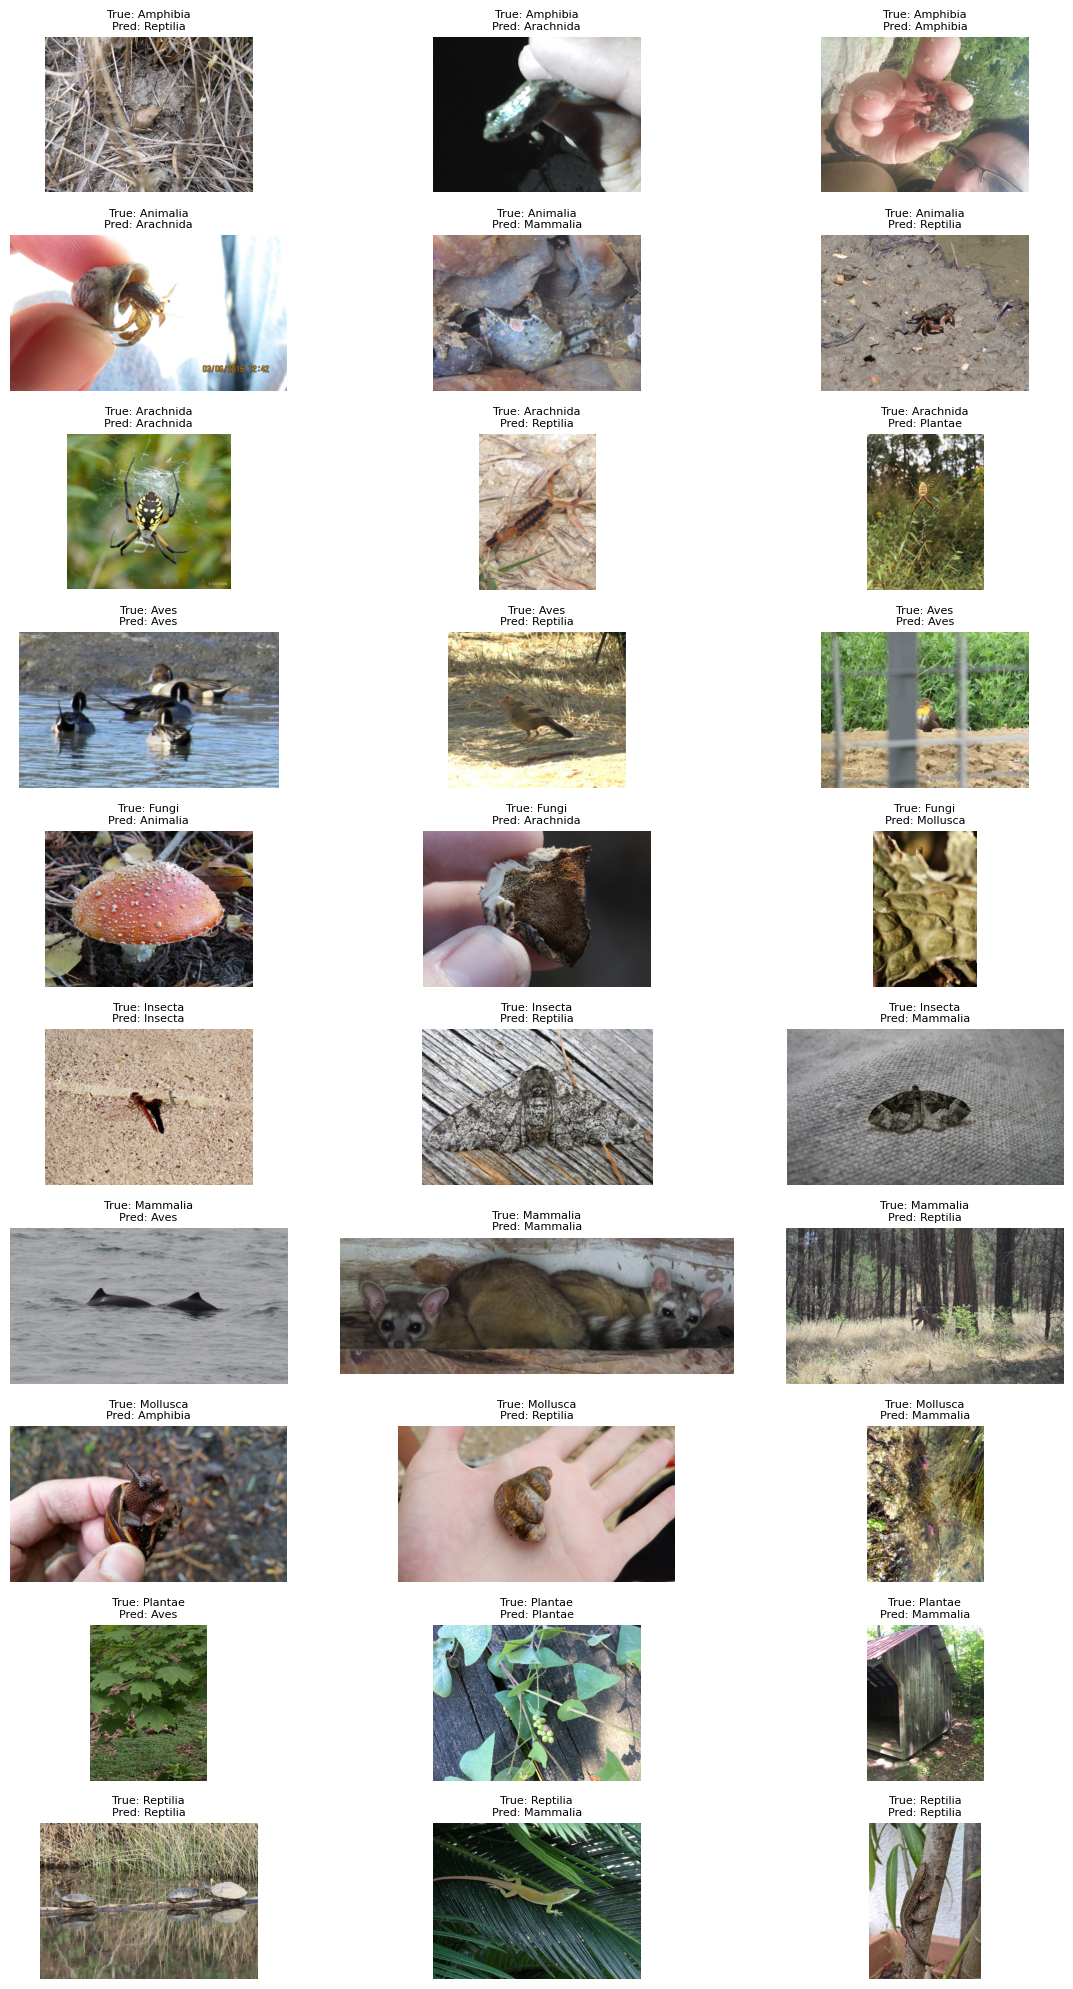

Prediction grid done


final_test_accuracy,▁█
final_test_accuracy,38.95


In [12]:
import os
import wandb
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Set device............................
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wandb initialization...................................
wandb.init(project="MA23M021_A2_Part-A", name="final_test_evaluation")


#Best sweep config model
best_model = ConvNet(
    in_channels=3,
    num_filters=[32, 64, 128, 256, 512],          
    filter_size=[3, 3, 3, 3, 3],               
    activation=nn.Mish(),                      
    stride=1,
    padding=1,
    pool_size=(2, 2),
    fc_dims = [128],
    #data_aug = 'No',
    num_classes=10,
    dropout=0.2,
    batch_norm='Yes'
).to(device)


#Data loaders.........................................
train_path = '/kaggle/input/natrue-12k/inaturalist_12K/train'
test_path = '/kaggle/input/natrue-12k/inaturalist_12K/val'

def load_dataloaders(train_data_dir, data_aug='Yes', batch_size=64, val_split=0.2):
    print('train data loading')
    basic_resize = transforms.Resize((224, 224))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    crop_resize = transforms.RandomResizedCrop(224)
    flip = transforms.RandomHorizontalFlip()
    color_shift = transforms.ColorJitter(0.2, 0.2, 0.2, 0.1)
    rotate = transforms.RandomRotation(20)

    if data_aug == 'Yes':
        transform_pipeline = transforms.Compose([
            crop_resize, color_shift, flip, rotate, to_tensor, normalize
        ])
    else:
        transform_pipeline = transforms.Compose([
            basic_resize, to_tensor, normalize
        ])

    full_dataset = ImageFolder(root=train_data_dir, transform=transform_pipeline)
    total_len = len(full_dataset)
    val_len = int(val_split * total_len)
    train_len = total_len - val_len
    train_set, val_set = torch.utils.data.random_split(full_dataset, [train_len, val_len], generator=torch.Generator().manual_seed(42))
    return {
        'train': train_set,
        'val': val_set,
        'classes': full_dataset.classes
    }

def load_test_loader(test_dir, data_aug='No', batch_size=64):
    print('test data loading')
    if data_aug == 'Yes':
        transform_pipeline = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
            transforms.RandomRotation(20),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])
    else:
        transform_pipeline = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        ])

    test_dataset = ImageFolder(root=test_dir, transform=transform_pipeline)
    return test_dataset

#Training the model................................................
def model_train(model, train_data, val_data, epochs=5):
    print('training strt')
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        correct, total = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        acc = correct / total * 100
        print(f"Epoch {epoch+1}/{epochs}, Train Accuracy: {acc:.2f}%")

# evaluation on test....................................
def evaluate_test(model, test_loader):
    print('testing')
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total * 100
    print(f"Test Accuracy: {acc:.2f}%")
    wandb.log({'final_test_accuracy': acc})

# Prediction grid..................................
def plot_predictions_grid(model, class_names, device):
    print('prediction grid')
    model.eval()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    images, true_labels, pred_labels = [], [], []

    # Collecting 3 images per class (first 10 classes).............................
    for class_name in class_names[:10]:
        class_dir = os.path.join(test_path, class_name)
        img_files = sorted(os.listdir(class_dir))[:3]

        for img_file in img_files:
            image_path = os.path.join(class_dir, img_file)
            image = Image.open(image_path).convert('RGB')
            input_tensor = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
                pred = output.argmax(dim=1).item()

            images.append(np.array(image))  # original image as numpy array
            true_labels.append(class_name)
            pred_labels.append(class_names[pred])

    # Plotting 10x3 grid...........................................
    fig, axes = plt.subplots(10, 3, figsize=(12, 20))
    for i in range(10):
        for j in range(3):
            idx = i * 3 + j
            axes[i, j].imshow(images[idx])
            axes[i, j].axis('off')
            axes[i, j].set_title(f"True: {true_labels[idx]}\nPred: {pred_labels[idx]}", fontsize=8)

    plt.tight_layout()
    fig.savefig("predictions_grid.png", bbox_inches='tight')
    wandb.log({"Test Prediction Grid": wandb.Image("predictions_grid.png")})
    plt.show()


# Execute everything
data = load_dataloaders(train_path, data_aug='No', batch_size=64)
test_data = load_test_loader(test_path, data_aug='No', batch_size=64)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
train_data = data['train']
val_data = data['val']
class_names = sorted(os.listdir(test_path))


model_train(best_model, train_data, val_data, epochs=10)
evaluate_test(best_model, test_loader)
plot_predictions_grid(best_model, class_names, device)
wandb.finish()